In [64]:
import pandas as pd
import numpy as np
import math
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


In [65]:
df = pd.read_excel("../data/archive/Medicine_description.xlsx")
df.head(5)

,Drug_Name,Reason,Description
0,A CN Gel(Topical) 20gmA CN Soap 75gm,Acne,Mild to moderate acne (spots)
1,A Ret 0.05% Gel 20gmA Ret 0.1% Gel 20gmA Ret 0...,Acne,A RET 0.025% is a prescription medicine that i...
2,ACGEL CL NANO Gel 15gm,Acne,It is used to treat acne vulgaris in people 12...
3,ACGEL NANO Gel 15gm,Acne,It is used to treat acne vulgaris in people 12...
4,Acleen 1% Lotion 25ml,Acne,treat the most severe form of acne (nodular ac...


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22481 entries, 0 to 22480
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Drug_Name    22481 non-null  object
 1   Reason       22481 non-null  object
 2   Description  22467 non-null  object
dtypes: object(3)
memory usage: 527.0+ KB


### Data transformations

In [67]:
def remove_missing_rows(df):
    if all(col in df.columns for col in ["Description", "Drug_Name"]):
        # Drop rows where any of the specified columns have missing values
        return df.dropna(subset=["Description", "Drug_Name"])
    else:
        raise KeyError("One or more specified columns are not present in the DataFrame")
    

df = remove_missing_rows(df)

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22467 entries, 0 to 22480
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Drug_Name    22467 non-null  object
 1   Reason       22467 non-null  object
 2   Description  22467 non-null  object
dtypes: object(3)
memory usage: 702.1+ KB


### Data Visualizations

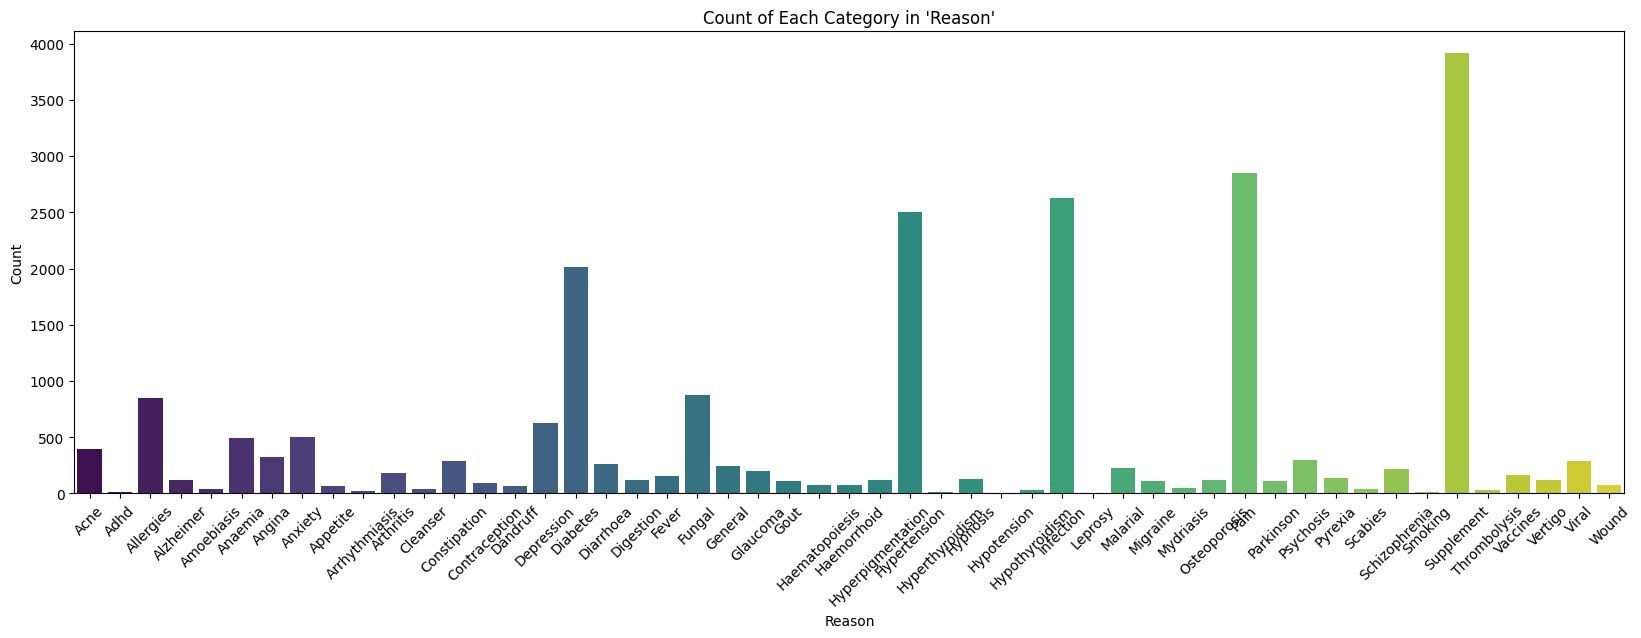

In [69]:
reason_counts = df.groupby("Reason").size()

# Plotting
plt.figure(figsize=(20, 6))
sns.barplot(x=reason_counts.index, y=reason_counts.values, palette="viridis")
plt.xlabel("Reason")
plt.ylabel("Count")
plt.title("Count of Each Category in 'Reason'")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

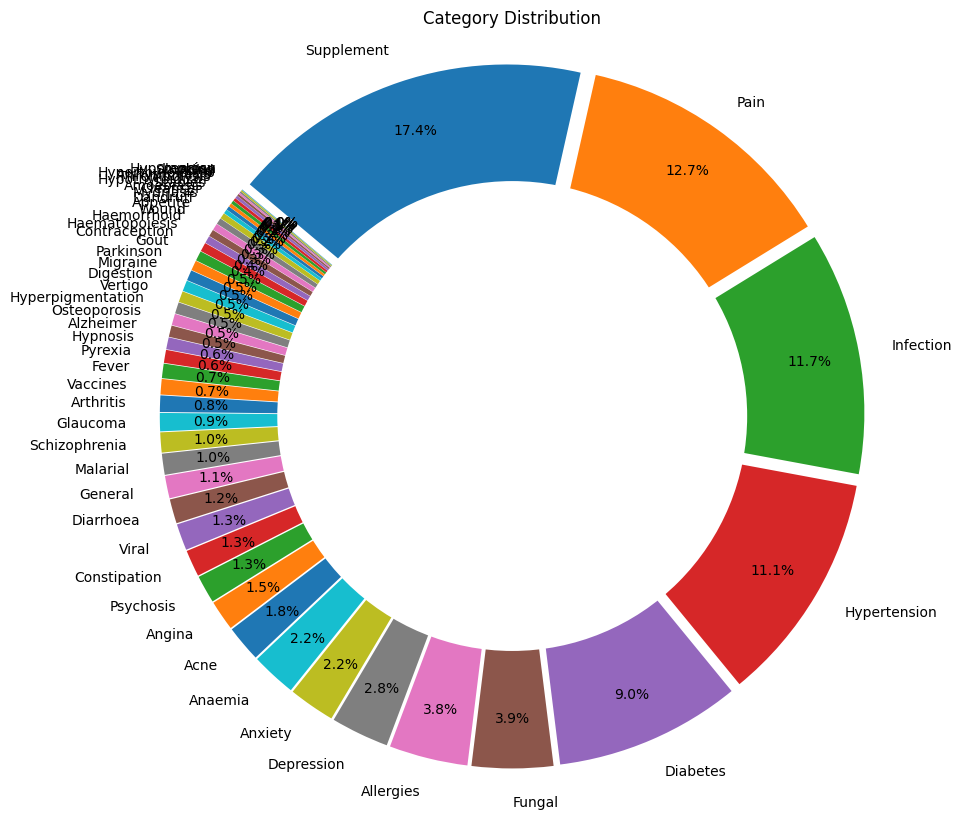

In [70]:
disease_counts = df["Reason"].value_counts()

explode = [0.05] * len(disease_counts) 

plt.figure(figsize=(10, 10))
plt.pie(disease_counts, labels=disease_counts.index, 
        autopct='%1.1f%%', startangle=140, counterclock=False,
        explode=explode, pctdistance=0.85, labeldistance=1.1)


centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')  
plt.title("Category Distribution")
plt.show()

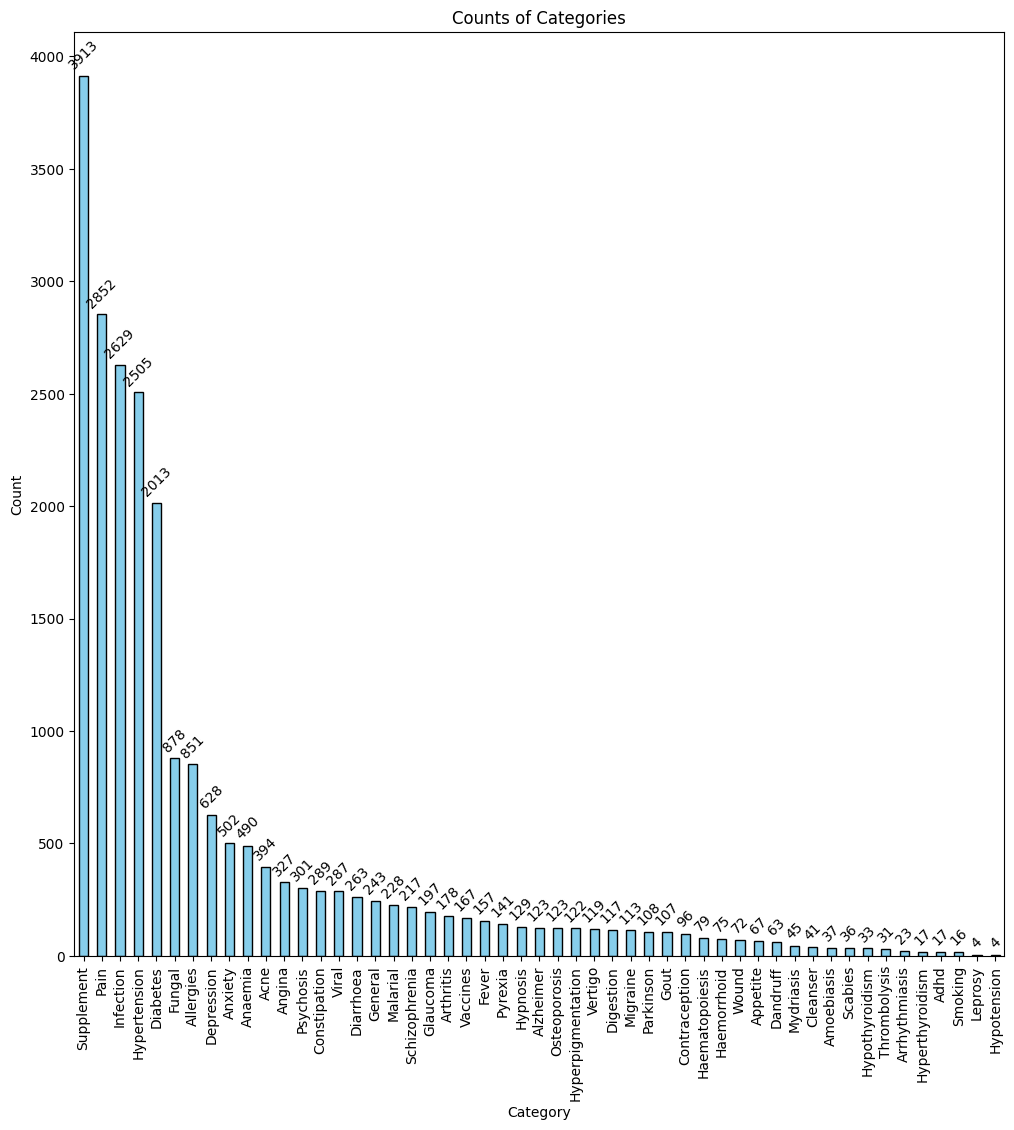

In [71]:
# bar plot
plt.figure(figsize=(12, 12))
ax = disease_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add title and labels
plt.title('Counts of Categories')
plt.xlabel('Category')
plt.ylabel('Count')

for i in ax.containers:
    ax.bar_label(i, label_type='edge', padding=3, rotation=45)

# Display the plot
plt.show()
plt.show()

### Data Transformations

In [72]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


sw_nltk = stopwords.words('english')
lemmatizer = WordNetLemmatizer()



def remove_stopwords(sentence):
    words = [word for word in sentence.split() if word.lower() not in sw_nltk]
    return " ".join(words)


def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in sw_nltk]
    return ' '.join(words)


def cleaning_text(df, col_name):
    df["cleaned_"+col_name] = df[col_name].apply(lambda x : preprocess_text(x))

    return df

new_df = cleaning_text(df, "Description")

### High frequency words

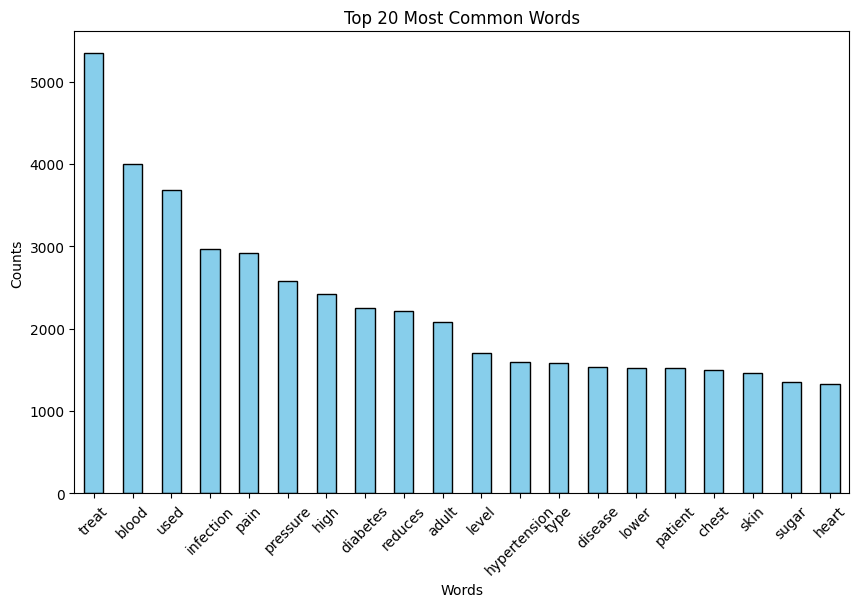

In [73]:
all_text = ' '.join(new_df["cleaned_Description"])
words = all_text.split()
word_series = pd.Series(words)
word_counts = word_series.value_counts()
top_10_words = word_counts.head(20)

# Plot the top 10 words and their counts
plt.figure(figsize=(10, 6))
top_10_words.plot(kind='bar', color='skyblue', edgecolor='black')

# Add title and labels
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Counts')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [74]:
import pandas as pd
import torch

from transformers import BertTokenizer, BertModel

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [75]:
def text_to_bert_embeddings(text, tokenizer, model):
    # Tokenize the text and convert it to input IDs, adding necessary tokens
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    
    # Get the hidden states from the last layer
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the last hidden states (embedding for each token)
    last_hidden_states = outputs.last_hidden_state
    
    # Mean pooling: Calculate the mean of the hidden states to get the sentence embedding
    sentence_embedding = last_hidden_states.mean(dim=1).squeeze().numpy()
    
    return sentence_embedding

In [76]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # Or another pre-trained model

new_df['bert_embeddings'] = new_df['cleaned_Description'].apply(lambda x: model.encode(x))


In [79]:
new_df["bert_embeddings"][1000].shape, new_df["bert_embeddings"][1].shape

((384,), (384,))

In [82]:
new_df.to_csv("../sentence_embeddings.csv")

In [ ]:
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)

    return dot_product/(norm_vec1* norm_vec2)

similairity = cosine_similarity(new_df["bert_embeddings"][0], new_df["bert_embeddings"][2])

In [ ]:
new_df["bert_embeddings"].shape

In [ ]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # Or another pre-trained model

new_sentence = "I am suffering from slight fever and headache"
new_embeddings = model.encode(new_sentence)

In [ ]:
similarity = cosine_similarity(new_df["bert_embeddings"][6533], new_embeddings)
similarity

In [ ]:
new_df["similarity_score"] = new_df["bert_embeddings"].apply(lambda x : cosine_similarity(x, 
                                                                       new_embeddings.reshape(-1,1)))

In [ ]:
new_df["similarity_score"].max()

In [ ]:
new_df[new_df["similarity_score"] == new_df["similarity_score"].max()[0]]["Drug_Name"]